# Import Settings

In [1]:
%load_ext Cython

In [2]:
import sys
import os
import argparse
import numpy as np
import pandas as pd
import warnings
import ujson as json
import logging as log

from pandas import DataFrame, Series
from os.path import expanduser, abspath, isfile, isdir, basename, splitext, \
	dirname, join, exists
from time import time
from datetime import date
import cPickle as pkl

#####################################
from datastructures.rgraph import Graph, weighted_degree
#####################################


from time import time
from os.path import exists, join, abspath, expanduser, basename, dirname, \
	isdir, splitext
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from datastructures.rgraph import make_graph, Graph
from datastructures.relationalpath import RelationalPath
from datastructures.relationalpath_sm import RelationalPathSM
from pathenum import get_paths as c_get_paths
## for streamminer,
from pathenum import get_paths_sm as c_get_paths_sm

##############################################
from algorithms.mincostflow.ssp import succ_shortest_path, disable_logging
from algorithms.relklinker.rel_closure import relational_closure as relclosure
from algorithms.klinker.closure import closure
##############################################

###################################################################
################# DATABASE and RELSIM SETUP #######################
###################################################################
# KG - DBpedia
HOME = abspath(expanduser('~/Documents/pcatxcore/knowledgestream/data/'))
if not exists(HOME):
	print 'Data directory not found: %s' % HOME
	print 'Download data per instructions on:'
	print '\thttps://github.com/shiralkarprashant/knowledgestream#data'
	print 'and enter the directory path below.'
	data_dir = raw_input('\nPlease enter data directory path: ')
	if data_dir != '':
		data_dir = abspath(expanduser(data_dir))
	if not os.path.isdir(data_dir):
		raise Exception('Entered path "%s" not a directory.' % data_dir)
	if not exists(data_dir):
		raise Exception('Directory does not exist: %s' % data_dir)
	HOME = data_dir
	# raise Exception('Please set HOME to data directory in algorithms/__main__.py')
PATH = join(HOME, 'kg/_undir/')
assert exists(PATH)
SHAPE = (6060993, 6060993, 663)
WTFN = 'logdegree'

# # relational similarity using TF-IDF representation and cosine similarity
# RELSIMPATH = join(HOME, 'relsim/coo_mat_sym_2016-10-24_log-tf_tfidf.npy')
# assert exists(RELSIMPATH)
##############################################################
RELSIMPATH = join(HOME, 'relsim/coo_mat_sym_2016-10-24_log-tf_tfidf.npy')
assert exists(RELSIMPATH)
##############################################################
# relational similarity using TF-IDF representation and cosine similarity

# relsim = np.load(RELSIMPATH)

# Date
DATE = '{}'.format(date.today())

# data types for int and float
_short = np.int16
_int = np.int32
_int64 = np.int64
_float = np.float

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

ImportError: No module named pathenum

In [6]:
	relsim = np.load(RELSIMPATH)

	outdir = abspath(expanduser('output/'))
	assert exists(outdir)
	datafile = abspath(expanduser('datasets/sample.csv'))
	assert exists(datafile)
	log.info('Launching {}..'.format('SM'))
	log.info('Dataset: {}'.format(basename(datafile)))
	log.info('Output dir: {}'.format(outdir))

	# read data
	df = pd.read_table(datafile, sep=',', header=0)
	log.info('Read data: {} {}'.format(df.shape, basename(datafile)))
	spo_df = df.dropna(axis=0, subset=['sid', 'pid', 'oid'])
	log.info('Note: Found non-NA records: {}'.format(spo_df.shape))
	df = spo_df[['sid', 'pid', 'oid']].values
	subs, preds, objs  = df[:,0].astype(_int), df[:,1].astype(_int), df[:,2].astype(_int)

	# load knowledge graph
	G = Graph.reconstruct(PATH, SHAPE, sym=True) # undirected
	assert np.all(G.csr.indices >= 0)
    
	base = splitext(basename(datafile))[0]


NameError: name 'RELSIMPATH' is not defined

## Some external test settings:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import heapq
inf = float('inf')

[00:36:19] CACHEDIR=/Users/himanshuahuja/.matplotlib
[00:36:19] Using fontManager instance from /Users/himanshuahuja/.matplotlib/fontList.json
[00:36:19] backend module://ipykernel.pylab.backend_inline version unknown
[00:36:19] backend module://ipykernel.pylab.backend_inline version unknown
[00:36:19] backend module://ipykernel.pylab.backend_inline version unknown


## Some Experiments on the graph

Shape of the data array: (48091479,)
Shape of the indices array: (48091479,)
Shape of the indptr array: (6060994,)


[00:36:20] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/Users/himanshuahuja/anaconda3/envs/pcatwd2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


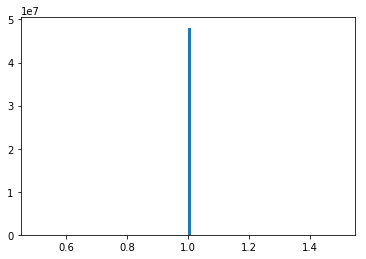

In [4]:
print "Shape of the data array: {}".format(G.csr.data.shape) #Undirected graph
print "Shape of the indices array: {}".format(G.csr.indices.shape) # for all the data points, there is one
print "Shape of the indptr array: {}".format(G.csr.indptr.shape) # for all the 6M entities
# To get an item on a particular position, just perform indexing on the self.csr matrix [node_row, rel_num * G.N + col_num]
plt.hist(G.csr.data, bins=100)
plt.show()

## Some settings for SM

In [5]:
triples = spo_df
y = triples['class'] # ground truth
triples = triples[['sid', 'pid', 'oid']].to_dict(orient='records')

pid_removal = triples[0]['pid']
print 'PID is: {}, with type: {}'.format(pid_removal, pid_removal.dtype)

PID is: 599.0, with type: float64


In [6]:
def weighted_degree(arr, weight='logdegree'):
	"""Returns a weighted version of the array."""
	if weight == 'degree':
		arr = 1./(1 + arr)
	elif weight == 'logdegree':
		arr = 1./(1 + np.log(arr))
	else:
		raise ValueError('Unknown weight function.')
	return arr

Specificity_wt has the shape: (48091479,)


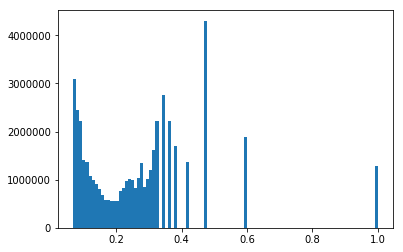

In [7]:
indegsim = weighted_degree(G.indeg_vec, weight=WTFN).reshape((1, G.N))
indegsim = indegsim.ravel()
targets = G.csr.indices % G.N #target nodes are the node values that would occur in the first E x E matrix
specificity_wt = indegsim[targets]
print "Specificity_wt has the shape: {}".format(specificity_wt.shape)
plt.hist(specificity_wt, bins=100)
plt.show()

#### Finding the relsim vector corresponding to predicate, p

Expected shape of the relsimvec is: (663,)
Shape of relsim_wt is: (48091479,)


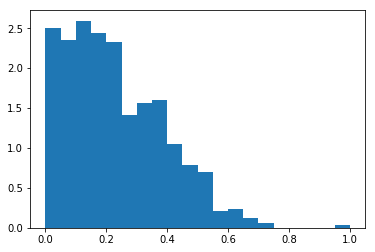

In [8]:
relations = (G.csr.indices - targets) / G.N #gives the respective relation values of those indices
relsimvec = np.array(relsim[int(pid_removal), :]) # specific to predicate p
print "Expected shape of the relsimvec is: {}".format(relsimvec.shape)
relsim_wt = relsimvec[relations] # with the size of relations as the number of relations
print "Shape of relsim_wt is: {}".format(relsim_wt.shape)
# Binning the cosine similarity plot
plt.hist(relsimvec,density=1, bins=20)
plt.show()

#### Removing the edge corresponding to p in the specificity matrix (soon to be data matrix)

=> Removing predicate 599.0 from KG.


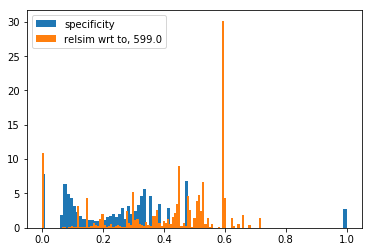

In [9]:
print '=> Removing predicate {} from KG.'.format(pid_removal)
eraseedges_mask = ((G.csr.indices - (G.csr.indices % G.N)) / G.N) == pid_removal
specificity_wt[eraseedges_mask] = 0
relsim_wt[eraseedges_mask] = 0
plt.hist(specificity_wt, density = 1, bins=100, label='specificity')
plt.hist(relsim_wt, density = 1, bins=100, label='relsim wrt to, {}'.format(pid_removal))
plt.legend()
plt.show()

#### Setting values changed in graph, setting backups

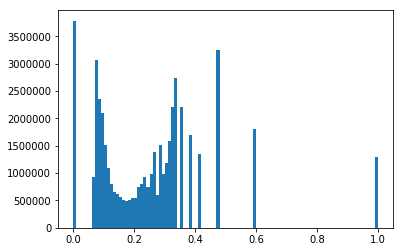

In [10]:
G.csr.data = specificity_wt.copy()
plt.hist(G.csr.data, bins=100)
plt.show()

##### Performing operation for a single (s, p, o)

In [11]:
def get_paths_sm_limited(G, s, p, o, relsim_wt, weight = 10.0, maxpaths=-1, top_n_neighbors=5):
	# "Returns all paths of length `length` starting at s and ending in o."
	path_stack = [[s]]
	weight_path_stack = [[0.0]]
	relpath_stack = [[-1]]
	discoverd_paths = []
	print 'We\'re checking the path: ({}, {}, {})'.format(s, p, o)
	while len(path_stack) > 0:
		# print 'Stack: {} {}'.format(path_stack, relpath_stack)
		curr_path = path_stack.pop()
		curr_relpath = relpath_stack.pop()
		node = curr_path[-1]
		curr_path_weight = weight_path_stack.pop()
		# print 'Node: {}'.format(node)
		total_path_weight = np.sum(curr_path_weight)
		if total_path_weight <= weight:
			if int(node) == int(o):
				print 'The total weight of the path is: {}'.format(np.sum(curr_path_weight))
				path = RelationalPathSM(
					s, p, o, 0., len(curr_path)-1, curr_path, curr_relpath, curr_path_weight
				)
				discoverd_paths.append(path)
				if maxpaths != -1 and len(discoverd_paths) >= maxpaths:
					print "Exceeded number of paths!"
					break
				continue
		elif total_path_weight > weight:
			#print 'Discarded path with weight'
			continue
		# print "Node is: {}, o is: {}, s is: {}, p is: {}".format(node, o, s, p)
		relnbrs, data = G.get_neighbors_sm(int(node))
		ordering = np.argsort(data)
		relnbrs = relnbrs[:, ordering]
		# print 'Data vector is: {}'.format(data)
		# print(data)
		range = relnbrs.shape[1] if relnbrs.shape[1] < top_n_neighbors else top_n_neighbors
		for i in xrange(range):
			rel, nbr = relnbrs[:, i]
			# print "rel is: {}, nbr is: {}".format(rel, nbr)
			path_stack.append(curr_path + [nbr])
			weight_path_stack.append(curr_path_weight + [data[i]])
			relpath_stack.append(curr_relpath + [rel])
	return discoverd_paths

In [12]:
def single_spo_test(G, idx, triples, y, relsim_wt, features=None):
	# Hyperparameter Setting:
	return_features = False
	if features is None:
		return_features = True
		features, pos_features, neg_features = set(), set(), set()
	measurements = []
	G_bak = {
	'data': G.csr.data.copy(),
	'indices': G.csr.indices.copy(),
	'indptr': G.csr.indptr.copy()
	}
	triple = triples[idx]
	sid, pid, oid = triple['sid'], triple['pid'], triple['oid']
	label = y[idx]
	targets = G.csr.indices % G.N #shift this function to the caller
	G.csr.data[targets == oid] = 1 # no cost for target t => max. specificity.
	G.csr.data = np.multiply(relsim_wt, G.csr.data)
	plt.hist(G.csr.data, density = 1, bins=100)
	plt.show()
	# PERFORM PATH EXTRACTION
	#paths = get_paths_sm_limited(G, sid, pid, oid, relsim_wt, \
			#weight = weight, maxpaths=200, top_n_neighbors=1000)
# 	rp = relclosure(G, int(sid), int(pid), int(oid), kind='metric', linkpred=False)
# 	paths = {}
#     paths['path'] = rp.path
	paths = yenKSP(G, sid, pid, oid)
	print "Extraction complete for, s:{}, p:{}, o:{}".format(sid, pid, oid)
# 	print '{}'.format(rp.score)
# 	for pth in paths:
# 		ff =  tuple(pth.relational_path)
# 		if ff not in features:
# 			features.add(ff)
# 			if label == 1:
# 				pos_features.add(ff)
# 			if label == 0:
# 				neg_features.add(ff)
# 			else:
# 				raise Exception("Unknown class label: {}".format(label))
# 		triple_feature[ff] = triple_feature.get(ff, 0) + 1
# 	measurements.append(triple_feature)
# 	sys.stdout.flush()
	#Restoring backup
	np.copyto(G.csr.data, G_bak['data'])
	np.copyto(G.csr.indices, G_bak['indices'])
	np.copyto(G.csr.indptr, G_bak['indptr'])

In [13]:
def relax(weight, u, v, r, Dist, prev):
	d = Dist.get(u, inf) + weight
	if d < Dist.get(v, inf):
		Dist[v] = d
		prev[v] = (-weight, u, r)

def get_shortest_path(G, sid, pid, oid):
	#making sure that nodes are integers:
	# discovered_path = []
	sid = int(sid)
	oid = int(oid)
	#prev is of the type: [weight, node, relation]
	Dist, visited, priority_q, prev = {sid:0}, set(), [(0,sid)], {sid:(0, -1, -1)}
	path_stack, rel_stack, weight_stack = [], [], []
	while priority_q:
		_, u = heapq.heappop(priority_q)
		if u == oid:
			k = u
			path_stack = [oid]
			while prev[k][1] != -1:
				path_stack.insert(0, prev[k][1])
				print
				rel_stack.insert(0, prev[k][2])
				weight_stack.insert(0, prev[k][0])
				k = prev[k][1]
			break
		if u in visited:
			continue
		visited.add(u)
		# get the neighbours and cost of the node u
		# returns [relations, neighbors, cost]
		rels, nbrs, costs = G.get_neighbors_sm_unpacked(int(u))
		for rel, nbr, cost in zip(rels, nbrs, costs): # for the iteration through keys
			if cost != 0:
				relax(-cost, u, nbr, rel, Dist, prev)
				heapq.heappush(priority_q, (-cost, nbr))
				# discovered_path = RelationalPathSM(sid, pid, oid, 0., len(path_stack)-1, ..)  								  path_stack, rel_stack, weight_stack)
	return path_stack, rel_stack, weight_stack

In [14]:
def yenKSP(G, sid, pid, oid, K = 20):
	discovered_paths = []
	path_stack, rel_stack, weight_stack = get_shortest_path(G, sid, pid, oid)
	if not path_stack:
		return discovered_paths
	A = [{'path_total_cost': np.sum(weight_stack),
		'path': path_stack,
		'path_rel': rel_stack,
		'path_weights': weight_stack}]
	B = []
	for k in xrange(1, K):
		for i in xrange(0, len(A[-1]['path'])-1):
			spurNode = A[-1]['path'][i]
			rootPath = A[-1]['path'][:i+1]
			rootPathRel = A[-1]['path_rel'][:i]
			rootPathWeights = A[-1]['path_weights'][:i]
			#print "rp: {}, rpr: {}, rpw: {}".format(len(rootPath), len(rootPathRel), len(rootPathWeights))
			removed_edges = []
			for path_dict in A:
				if len(path_dict['path']) > i and rootPath == path_dict['path'][:i+1]:
					#find the edge between ith and i+1th node
					edge = G.csr[path_dict['path'][i], path_dict['path_rel'][i]*G.N+path_dict['path'][i+1]]
					if edge == 0:
						continue
					removed_edges.append((path_dict['path'][i], path_dict['path'][i+1], path_dict['path_rel'][i], edge))
					edge = 0 #delete the edge
			spurPath, spurPathRel, spurPathWeights = get_shortest_path(G, spurNode, pid, oid)
			if spurPath:
				totalPath = rootPath[:-1] + spurPath
				totalDist = np.sum(rootPathWeights[:-1]) + np.sum(spurPathWeights)
				totalWeights = rootPathWeights[:-1] + spurPathWeights
				totalPathRel = rootPathRel[:-1] + spurPathRel
				potential_k = {'path_total_cost': totalDist,
							'path': totalPath,
							'path_rel': totalPathRel,
							'path_weights': totalWeights}
				if not (potential_k in B):
					B.append(potential_k)
			for removed_edge in removed_edges:
				G.csr[removed_edge[0], removed_edge[2]*G.N + removed_edge[1]] = removed_edge[3]
		if len(B):
			B = sorted(B, key=lambda k: k['path_total_cost'])
			A.append(B[0])
			B.pop(0)
		else:
			break
	for path_dict in A:
		discovered_paths.append(RelationalPathSM(sid, pid, oid, path_dict['path_total_cost'], len(path_dict['path'])-1, path_dict['path'], path_dict['path_rel'], path_dict['path_weights']))
	return discovered_paths

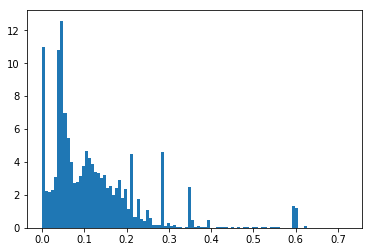





















20
Extraction complete for, s:392035.0, p:599.0, o:2115741.0


In [15]:
single_spo_test(G, 0, triples, y, relsim_wt)